In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import numpy as np
from dl_helper.rl.rl_env.lob_trade.lob_const import MAX_SEC_BEFORE_CLOSE

def calculate_time_difference(time_str1, time_str2, format_str="%Y-%m-%d %H:%M:%S"):
    # 将时间字符串转换为 datetime 对象
    time1 = datetime.strptime(time_str1, format_str)
    time2 = datetime.strptime(time_str2, format_str)
    
    # 计算时间差
    time_diff = time2 - time1
    
    # 转换为秒数（总秒数）
    seconds = abs(time_diff.total_seconds())
    
    return seconds

def calc_time_from_sec_fc(sec_fc):
    # 定义基准时间 15:00:00
    base_time = datetime.strptime("15:00:00", "%H:%M:%S")
    # print(base_time )
    
    # 校正 sec_fc 
    if sec_fc < 1:
        sec_fc *= MAX_SEC_BEFORE_CLOSE

    # 计算时间差
    time_delta = timedelta(seconds=int(sec_fc))
    
    # 计算当前时间：15:00:00 减去 sec_fc
    current_time = base_time - time_delta
    # print(current_time )

    # 提取小时、分钟、秒
    hours = current_time.hour
    minutes = current_time.minute
    seconds = current_time.second + (current_time.microsecond / 1_000_000)
    
    # 格式化输出时间
    return f"{hours:02d}:{minutes:02d}:{seconds:06.3f}"

def calc_sec_fc_from_time(time_str):
    # 将时间字符串转换为 datetime 对象
    time_str = time_str if len(time_str) == 8 else time_str[-8:]
    time1 = datetime.strptime(time_str, "%H:%M:%S")
    # 计算时间差
    time_diff = datetime.strptime("15:00:00", "%H:%M:%S") - time1
    secs = time_diff.total_seconds()
    print(secs)
    return np.float32(secs / MAX_SEC_BEFORE_CLOSE)

def get_timestamp(date_str, time_str):
    return int(datetime.strptime(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:8]}", "%Y-%m-%d %H:%M:%S").timestamp())

import pickle, os, random
import pandas as pd
import numpy as np
import random
import pytz

import matplotlib.pyplot as plt
from dl_helper.rl.rl_utils import date2days, days2date
from dl_helper.rl.rl_env.lob_trade.lob_const import MAX_SEC_BEFORE_CLOSE
from dl_helper.rl.rl_env.lob_trade.lob_const import USE_CODES, STD_REWARD
from dl_helper.rl.custom_imitation_module.dataset import LobTrajectoryDataset
from dl_helper.rl.rl_env.lob_trade.lob_expert import LobExpert_file
from dl_helper.rl.rl_env.lob_trade.lob_env import LOB_trade_env
from dl_helper.tool import max_profit_reachable, plot_trades_plt, plot_trades
expert = LobExpert_file(pre_cache=False, cache_debug=True)

from dl_helper.rl.rl_env.lob_trade.lob_const import DATA_FOLDER
from dl_helper.rl.custom_imitation_module.rollout import rollouts_filter
from imitation.data import rollout
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecCheckNan
from imitation.data.wrappers import RolloutInfoWrapper
from dl_helper.rl.rl_utils import date2days, days2date

data_config = {
    'his_len': 10,# 每个样本的 历史数据长度
    'need_cols': [item for i in range(1) for item in [f'BASE卖{i+1}价', f'BASE卖{i+1}量', f'BASE买{i+1}价', f'BASE买{i+1}量']],
}

dates = os.listdir(DATA_FOLDER)
dates = [i for i in dates if i.endswith('.pkl')]
date = random.choice(dates).split('.')[0]
date = '20250331'
print(date)

20250331


In [2]:
# 生成指定日期标的的空白动作轨迹
data_folder = DATA_FOLDER
need_pos_0, need_pos_1 = True, False
need_pos_0, need_pos_1 = False, True
need_pos_0, need_pos_1 = True, True
symbol = [
    '513130',
]

env = LOB_trade_env(
    config={
        'his_len': data_config['his_len'],
        'need_cols': data_config['need_cols'],
        'use_symbols': symbol,
        'random_begin_in_day': False,
        'train_folder': r'C:\Users\lh\Desktop\temp\lob_env',
        'train_title': 'temp',
    },
    debug_obs_date=date2days(date),
    debug_init_pos=0,
    data_folder=data_folder,
)

data_dict = {}
wait_symbol = symbol.copy()
while wait_symbol:
    obss = []
    obs, info = env.reset()

    _symbol_str = USE_CODES[int(obs[-4])]
    print((obs[-4], _symbol_str))
    if _symbol_str in wait_symbol:
        wait_symbol.remove(_symbol_str)
    else:
        # 说明当天的数据遍历完成
        print(f'{date} 当天数据遍历完成')
        break

    done = False
    while not done:
        obss.append(obs)
        obs, reward, terminated, truncated, info = env.step(1)
        done = terminated or truncated

    single_obs_num = len(obss)
    print(f'标的 {_symbol_str} 当天样本数量: {single_obs_num * 2}')

    # 构造 obs
    no_pos = np.vstack(obss)# pos == 0 的部分
    has_pos = np.vstack(obss)# pos == 1 的部分
    has_pos[:, -2] = 1

    done_obs = []
    done_acts = []
    # balance_del_idx = []

    parts_list = []
    if need_pos_0:
        parts_list.append(no_pos)
    if need_pos_1:
        parts_list.append(has_pos)
    if _symbol_str not in data_dict:
        data_dict[_symbol_str] = {}
    for obs in parts_list:
        # 构造 acts
        acts = np.zeros(single_obs_num, dtype=np.int8)# 等待专家填充
        for i in range(single_obs_num):
            _obs = obs[i]
            _act = expert.get_action(_obs)
            acts[i] = _act

        # 截取 obs
        use_obs = obs[:, -3:].copy()

        # 不根据每日的数据进行样本均衡
        # 最终全部load数据后进行样本均衡
        # # 样本均衡
        # # 计算acts类别数量
        # acts_count = np.bincount(acts)
        # # 数量少的类别数量
        # acts_min_count = int(min(acts_count)) if len(acts_count) == 2 else 0
        # # 需要将采样的类别
        # need_sample_idx = []
        # for i, count in enumerate(acts_count):
        #     idx = np.where(acts == i)[0]
        #     if count > acts_min_count:
        #         print(f'act: {i}, count: {count}, 需要降采样, 删除样本数量: {count - acts_min_count}')
        #         # print(idx)
        #         # 随机采样
        #         sample_idx = np.random.choice(idx, acts_min_count, replace=False)
        #         # print(sample_idx)
        #     else:
        #         # 保留全部数据
        #         sample_idx = idx
        #     need_sample_idx.extend(sample_idx)
        # sorted_sample_idx = np.sort(need_sample_idx)
        # # 记录需要删除的idx列表
        # delete_idx = np.setdiff1d(np.arange(len(acts)), sorted_sample_idx)

        # # 当前 done_obs 中的样本数
        # cur_done_obs_length = sum([len(i) for i in done_obs])
        # balance_del_idx.append(delete_idx + cur_done_obs_length)

        # 添加 原始全样本 到完成列表
        done_obs.append(use_obs)
        done_acts.append(acts)

    # 合并数据
    data_dict[_symbol_str]['obs'] = np.concatenate(done_obs)
    data_dict[_symbol_str]['acts'] = np.concatenate(done_acts)
    # data_dict[_symbol_str]['balance_del_idx'] = np.concatenate(balance_del_idx)

for _symbol in data_dict:
    all_num = len(data_dict[_symbol]["acts"])
    print(f'{_symbol} 全样本数量: {all_num}')

    # balance_del_num = len(data_dict[_symbol]["balance_del_idx"])
    # balance_num = all_num - balance_del_num
    # print(f'{_symbol} 全样本数量: {all_num}, 平衡样本数量: {balance_num}')

dataset = LobTrajectoryDataset(data_config = data_config, data_dict = data_dict, data_type='test')
# dataset = LobTrajectoryDataset(data_config = data_config, data_dict = data_dict, data_type='train')
length = len(dataset)
print(f'训练样本数量: {length}')

2025-08-15 02:09:42 | lob_env.py:__init__:1493 - [117570000] init logger: C:\Users\lh\logs\temp_20250815.log
2025-08-15 02:09:42 | lob_env.py:__init__:124 - [train] debug_date: ['20250331']
2025-08-15 02:09:42 | lob_env.py:__init__:177 - [train] data_producer init done
2025-08-15 02:09:43 | lob_env.py:__init__:1553 - [117570000][train] init env done
2025-08-15 02:09:43 | lob_env.py:reset:1863 - [117570000][train] reset
2025-08-15 02:09:43 | lob_env.py:_pre_files:259 - [train] prepare files: ['20250331.pkl']
2025-08-15 02:09:43 | lob_env.py:_load_data:278 - [train] load date file: 20250331.pkl
2025-08-15 02:09:43 | lob_env.py:_load_data:366 - [train] init idxs: [[np.int64(22646), np.int64(27175), 8]]
2025-08-15 02:09:43 | lob_env.py:reset:1888 - acc reset: 0
(np.float32(8.0), '513130')
2025-08-15 02:09:44 | lob_env.py:step:1741 - [117570000][train] total sample: 500
2025-08-15 02:09:45 | lob_env.py:step:1741 - [117570000][train] total sample: 1000
2025-08-15 02:09:46 | lob_env.py:step:1

In [3]:
# i = 28
# print(data_dict[symbol]['obs'][i][0])
# calc_time_from_sec_fc(int(data_dict[symbol]['obs'][i][0] * 5.5*60*60)), _all_raw_data.iloc[14049 + i]['时间']

In [4]:
# i = 27
# data_dict[symbol]['acts'][i], _all_raw_data.iloc[14049 + i]['BS']

In [7]:
sample_idx = -200
# sample_idx = 4000
each_plus = 400

样本数量: 9058
样本索引: 9000
0.017979798838496208 > 356.0000170022249
20250331 513130 14:54:04.000
样本预期id: 513130_1743404044
样本真实id: 513130_1743404044
样本在当天数据中的索引 27117
样本时间: 2025-03-31 14:54:04
数据起始 4575 4680
扩展数据起始 4375 4738
持仓: 1, 动作: 买, 时间: 2025-03-31 14:54:04


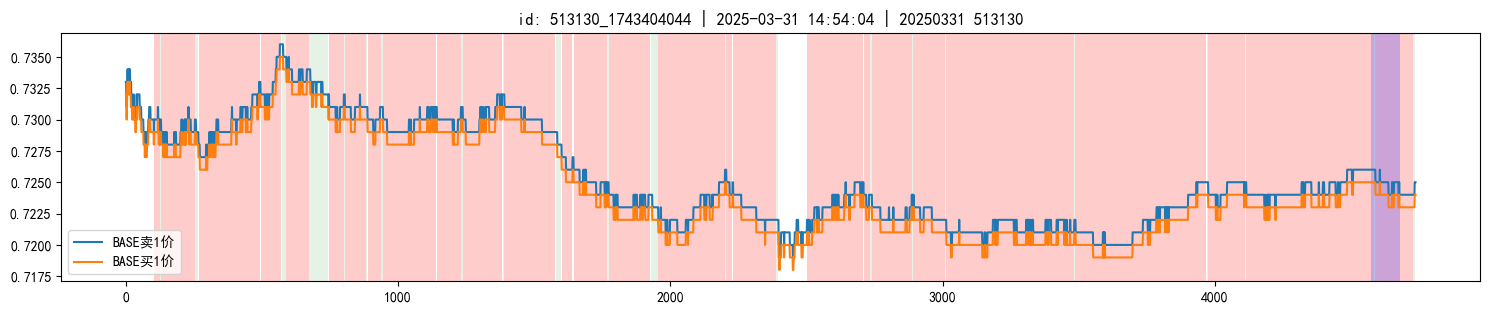

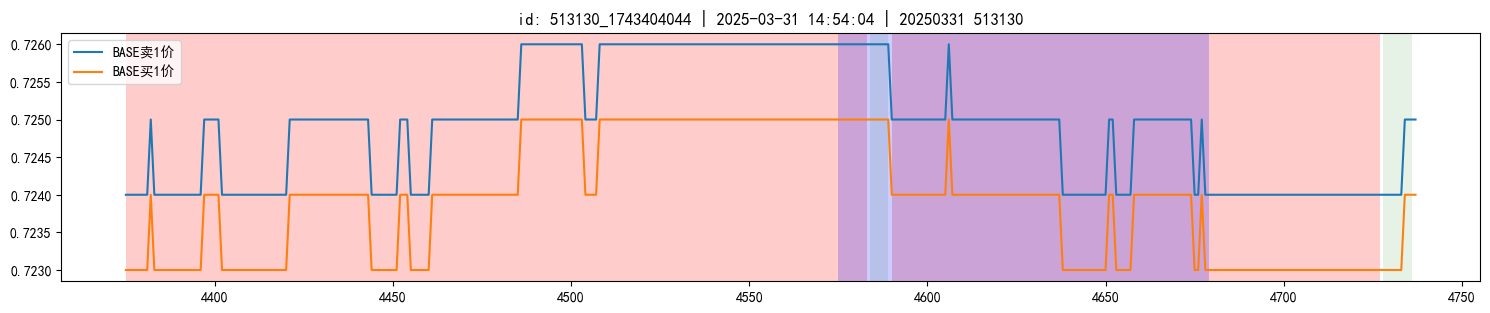

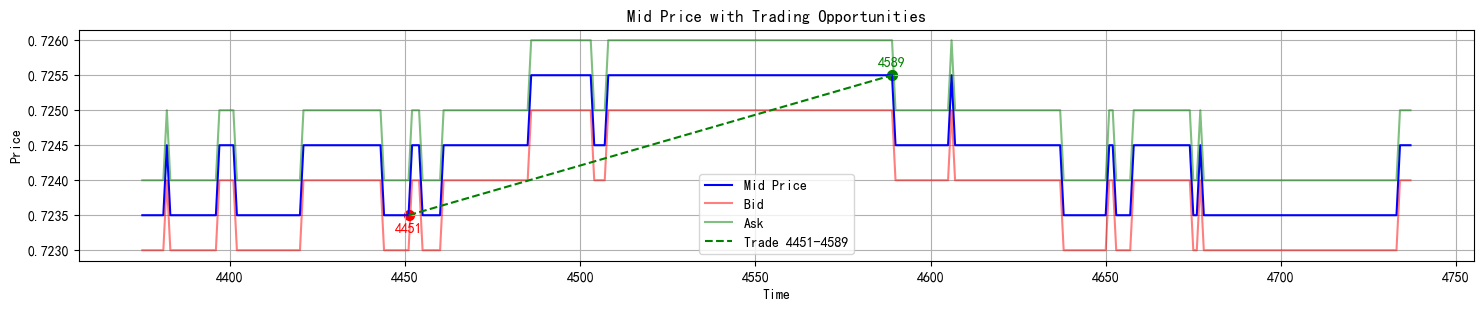

In [30]:
print(f'样本数量: {length}')

sample_idx += each_plus

# sample_idx = 2200
# sample_idx = 750
# sample_idx = 3850 + 15

extra_length = 200
# extra_length = 500
# extra_length = 10
print(f'样本索引: {sample_idx}')

# # 随机样本
# sample_idx = random.randrange(length)
# # sample_idx = 2800 - 200
# print(f'样本索引: {sample_idx}')

obs, act = dataset[sample_idx]

obs[:-4], act, obs[-4:]

code = USE_CODES[int(obs[-4])]
date = days2date(int(obs[-1]))
sec_fc = float(obs[-3]) * MAX_SEC_BEFORE_CLOSE
print(float(obs[-3]), '>' ,sec_fc)

dt = calc_time_from_sec_fc(sec_fc)
print(date, code, dt)

_id = f'{code}_{get_timestamp(date, dt)}'
print(f'样本预期id: {_id}')

# 获取训练数据的历史均值方差
file = rf'{DATA_FOLDER}\{date}.pkl'
_ids, _mean_std, _x, _all_raw_data = pickle.load(open(file, 'rb'))

# 填充 距离市场关闭的秒数
dt = datetime.strptime(f'{date} 15:00:00', '%Y%m%d %H:%M:%S')
dt = pytz.timezone('Asia/Shanghai').localize(dt)
close_ts = int(dt.timestamp())
before_market_close_sec = np.array([int(i.split('_')[1]) for i in _all_raw_data['id']])
_all_raw_data['sec'] =( close_ts - before_market_close_sec) / MAX_SEC_BEFORE_CLOSE

# 查找第idx
idx = 0
for _idx, __id in enumerate(_ids):
    if __id[:6] == code and __id[7:] >= _id[7:]:
        if __id[7:] == _id[7:]:
            # 完美匹配
            idx = _idx
        else:
            # 使用距离最近的点
            _pre_ts = _ids[_idx-1][7:]
            _cur_ts = __id[7:]
            if abs(int(_pre_ts) - int(_id[7:])) > abs(int(_cur_ts) - int(_id[7:])):
                idx = _idx
            else:
                idx = _idx - 1

        print(f'样本真实id: {_ids[idx]}')
        break

dt = datetime.fromtimestamp(int(_ids[idx][7:]))
print(f'样本在当天数据中的索引 {idx}')
print(f'样本时间: {dt}')

# 标的所属的 _ids
symbol_ids = [i for i, _id in enumerate(_ids) if _id[:6] == code]
min_a, max_a = _x[symbol_ids[0]][0], _x[symbol_ids[-1]][1]-1

# 填充所有的 act
# act_a, act_b = _x[symbol_ids[0]][1] - 1, _x[symbol_ids[-1]][1]
acts_indexs = [_x[i][1] - 1 for i in symbol_ids][:-1]
if need_pos_0 and need_pos_1: 
    _all_raw_data.loc[acts_indexs, 'BS'] = data_dict[code]['acts'][: len(data_dict[code]['acts'])//2] if obs[-2] == 0 else data_dict[code]['acts'][len(data_dict[code]['acts'])//2:]
else:
    _all_raw_data.loc[acts_indexs, 'BS'] = data_dict[code]['acts']
_all_raw_data = _all_raw_data.iloc[min_a: max_a+1].reset_index(drop=True)

# 可视化中间价格
a, b = _x[idx]
a, b = a-min_a, b-min_a
print('数据起始', a, b)
ea,eb = a-extra_length, b+extra_length

ea = max(0, ea)
eb = min(len(_all_raw_data), eb)
print('扩展数据起始',ea, eb)

print(f'持仓: {int(obs[-2])}, 动作: {"卖" if act==1 else "买"}, 时间: {str(dt)}')

fig, ax = plt.subplots(figsize=(15, 3))
data = _all_raw_data
mid = data.loc[:, ['BASE卖1价', 'BASE买1价']]
mid.plot(ax=ax)
# 获取 BS 列
bs = data['BS']
# 找到 BS 变化的边界
changes = bs.diff().ne(0).index[bs.diff().ne(0)].tolist()
changes = changes + [max_a]  # 添加起点和终点
# 批量填充 BS=0（淡红色）和 BS=1（淡绿色）的区域
for i in range(len(changes)-1):
    start, end = changes[i], changes[i+1]
    if bs[start] == 0:
        ax.axvspan(start, end-1, facecolor='red', alpha=0.2)  # BS=0 填充淡红色
    elif bs[start] == 1:
        ax.axvspan(start, end-1, facecolor='green', alpha=0.1)  # BS=1 填充淡绿色
ax.axvspan(a, b-1, facecolor='blue', alpha=0.2)
plt.tight_layout()
plt.title(f'id: {_ids[idx]} | {dt} | {date} {code}')
# plt.fill_between(range(a-min_a, len(mid) - (max_a+1-b)), mid.values.min(), mid.values.max(), color='blue', alpha=0.1)
# Show the plot
plt.show()

# 切片
fig, ax = plt.subplots(figsize=(15, 3))
data = _all_raw_data.iloc[ea: eb]
# mid = data.loc[:, ['BASE卖1价', 'BASE买1价']].reset_index(drop=True)
mid = data.loc[:, ['BASE卖1价', 'BASE买1价']]
mid.plot(ax=ax)
# 获取 BS 列
# bs = data['BS'].reset_index(drop=True)
bs = data['BS']
# 找到 BS 变化的边界
changes = bs.diff().ne(0).index[bs.diff().ne(0)].tolist()
changes = changes + [eb-1]  # 添加起点和终点
# 批量填充 BS=0（淡红色）和 BS=1（淡绿色）的区域
for i in range(len(changes)-1):
    start, end = changes[i], changes[i+1]
    if bs[start] == 0:
        ax.axvspan(start, end-1, facecolor='red', alpha=0.2)  # BS=0 填充淡红色
    elif bs[start] == 1:
        ax.axvspan(start, end-1, facecolor='green', alpha=0.1)  # BS=1 填充淡绿色
ax.axvspan(a, b-1, facecolor='blue', alpha=0.2)
plt.tight_layout()
plt.title(f'id: {_ids[idx]} | {dt} | {date} {code}')
plt.show()

#############################
# 绘制 trades
#############################
plot_data = _all_raw_data.loc[:, ['时间', 'id', 'BASE卖1价', 'BASE买1价']].iloc[ea: eb].copy().reset_index(drop=True)
begin_diff = ea
plot_data['mid_price'] = (plot_data['BASE卖1价'] + plot_data['BASE买1价']) / 2
trades, total_log_return, _valleys, _peaks = max_profit_reachable(
    plot_data['BASE买1价'], 
    plot_data['BASE卖1价'], 
    rep_select='last',
)# 增加随机泛化
plot_trades_plt(plot_data['mid_price'], trades, _valleys, _peaks, plot_data['BASE买1价'], plot_data['BASE卖1价'],(18, 3), False, begin_diff)

In [7]:
# buy = 7.027
# sell = 7.028

# ret = np.log((sell * (1 - 5e-5))/ (buy*(1+5e-5)))
# ret

In [8]:
# # 14:59:32
# begin, end = 3000, 3100
# _all_raw_data[['sec','时间', 'id', 'BASE卖1价', 'BASE买1价','BS']].iloc[begin: end]
# # _all_raw_data[['时间', 'id', 'BASE卖1价', 'BASE买1价', 'BS']].tail(5)

In [9]:
# begin, end = 440, 650
# d = _all_raw_data.loc[:, ['时间', 'id', 'BASE卖1价', 'BASE买1价']].iloc[begin: end].copy().reset_index(drop=True)
# d['mid_price'] = (d['BASE卖1价'] + d['BASE买1价']) / 2
# trades, total_log_return, _valleys, _peaks = max_profit_reachable(
#     d['BASE买1价'], 
#     d['BASE卖1价'], 
#     rep_select='last',
# )
# plot_trades_plt(d['mid_price'], trades, _valleys, _peaks, d['BASE买1价'], d['BASE卖1价'],(18, 3), True)

# 储存检查过的数据

In [7]:
# 之后的修改需要通过，不能导致原先的数据发生改变
file_path = r'C:\Users\lh\Desktop\temp\check_data.pkl'
if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        check_data = pickle.load(f)
else:
    check_data = {}

# 遍历obs 和 acts , 按照 样本id 分组
# f'{_symbol}_{_sample_date}_{_sample_pos}'
temp_data = {}
for _symbol in data_dict:
    for _obs, _act in zip(data_dict[_symbol]['obs'], data_dict[_symbol]['acts']):
        _sample_date = days2date(int(_obs[-1]))
        _sample_pos = int(_obs[-2])
        _sample_id = f'{_symbol}_{_sample_date}_{_sample_pos}'
        if _sample_id not in temp_data:
            temp_data[_sample_id] = {
                'obs': [],
                'acts': []
            }
        temp_data[_sample_id]['obs'].append(_obs)
        temp_data[_sample_id]['acts'].append(_act)

# 将 temp_data 合并成 ndarray
for _sample_id in temp_data:
    temp_data[_sample_id]['obs'] = np.array(temp_data[_sample_id]['obs'])
    temp_data[_sample_id]['acts'] = np.array(temp_data[_sample_id]['acts'])

# 检查 check_data 中是否包含相同的样本id，需要检查是否一致
for _sample_id in temp_data:
    if _sample_id in check_data:
        if np.all(temp_data[_sample_id]['obs'] == check_data[_sample_id]['obs']) and np.all(temp_data[_sample_id]['acts'] == check_data[_sample_id]['acts']):
            print(f'样本id: {_sample_id} 一致')
        else:
            print(f'样本id: {_sample_id} 不一致')
            overwrite = input('是否覆盖？（y/n）')
            if overwrite == 'y':
                check_data[_sample_id] = temp_data[_sample_id]
            else:
                raise Exception(f'停止写入')

# 更新数据到 check_data
for _sample_id in temp_data:
    check_data[_sample_id] = temp_data[_sample_id]

# 保存数据到文件
with open(file_path, 'wb') as f:
    pickle.dump(check_data, f)

print(f'样本数量: {len(check_data)}')

样本id: 518880_20250514_0 不一致
样本数量: 34


# 检查全部已有的样本

In [1]:
from tqdm import tqdm
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def print_diff_row(check_act, acts, check_obs):
    # 找出元素不一致的索引
    differing_indices = np.where(check_act != acts)[0]
    
    if len(differing_indices) == 0:
        print("没有不一致的索引")
        return
    
    # 找到连续的索引块
    diff = np.diff(differing_indices)
    breaks = np.where(diff != 1)[0] + 1
    blocks = np.split(differing_indices, breaks)
    
    # 打印结果
    print("不一致的索引 (按连续块合并):")
    for block in blocks:
        if len(block) == 1:
            print(f"索引: [{block[0]}] 时间: {calc_time_from_sec_fc(check_obs[block[0]][-3])}({check_obs[block[0]][-3]:.6f})")
        else:
            print(f"时间起点: {calc_time_from_sec_fc(check_obs[block[0]][-3])}({check_obs[block[0]][-3]:.6f}) 终止时间: {calc_time_from_sec_fc(check_obs[block[-1]][-3])}({check_obs[block[-1]][-3]:.6f}) 索引范围: [{block[0]}:{block[-1]}] len: {len(block)}")
        
        # for i in block:
        #     print(f'[{i}]', calc_time_from_sec_fc(check_obs[i][0]), check_obs[i])
        #     # print(f'[{i}]', "check_act:", check_act[i])
        #     # print(f'[{i}]', "act:", acts[i])
        print()  # 每个块后加空行

def plot_diff_row(sample_id, check_act, acts, check_obs, lob_data, begin=None, end=None):
    # 计算 mid 价格
    ask_1_price = lob_data['BASE卖1价']
    bid_1_price = lob_data['BASE买1价']
    mid = (ask_1_price + bid_1_price) / 2
    x = np.arange(len(mid))

    def plot_segment(title, x_seg, mid_seg, ask, bid, act_seg, acts_seg):
        plt.plot(x_seg, mid_seg, label='Mid Price', color='blue')
        plt.plot(x_seg, ask, label='Ask', color='green')
        plt.plot(x_seg, bid, label='Bid', color='red')

        # === 灰色网格线填充：act 为 0 的连续块 ===
        zero_indices = np.where(acts_seg == 0)[0]
        if len(zero_indices) > 0:
            diff = np.diff(zero_indices)
            breaks = np.where(diff != 1)[0] + 1
            zero_blocks = np.split(zero_indices, breaks)

            for block in zero_blocks:
                start_x = x_seg[block[0]]
                end_x = x_seg[block[-1]]
                min_width = 0.3  # 或者你认为合适的像素宽度
                width = max(end_x - start_x, min_width)

                rect = patches.Rectangle(
                    (start_x, plt.ylim()[0]), width, plt.ylim()[1] - plt.ylim()[0],
                    linewidth=0,
                    facecolor='none',
                    edgecolor='gray',
                    hatch='////',  # 网格样式，可以试试 '///', 'xxx', '...' 等
                    zorder=0
                )
                plt.gca().add_patch(rect)

        # === 红色背景：check_act 与 acts 不一致 ===
        mismatch_indices = np.where(act_seg != acts_seg)[0]
        if len(mismatch_indices) > 0:
            diff = np.diff(mismatch_indices)
            breaks = np.where(diff != 1)[0] + 1
            mismatch_blocks = np.split(mismatch_indices, breaks)

            for block in mismatch_blocks:
                start_x = x_seg[block[0]]
                end_x = x_seg[block[-1]]
                plt.axvspan(start_x, end_x, color='red', alpha=0.3)

                # 标注起止位置（显示全局索引）
                y_pos = max(mid_seg) + (max(mid_seg) - min(mid_seg)) * 0.02
                plt.text(start_x, y_pos, f'{start_x}', ha='center', va='bottom', fontsize=12, color='green')
                if end_x != start_x:
                    plt.text(end_x, y_pos, f'{end_x}', ha='center', va='bottom', fontsize=12, color='green')

        plt.xlabel("Index")
        plt.ylabel("Mid Price")
        plt.title(title)
        plt.legend()
        plt.tight_layout()

    # === 全局图 ===
    plt.figure(figsize=(15, 4))
    plot_segment(sample_id, x, mid, ask_1_price, bid_1_price, check_act, acts)
    plt.show()

    # === 局部图（如果指定） ===
    if begin is not None and end is not None:
        begin = max(0, begin)
        end = min(len(mid), end)
        if end > begin:
            x_local = np.arange(begin, end)  # 使用全局 index，避免错位
            mid_local = mid[begin:end]
            ask_1_price_local = ask_1_price[begin:end]
            bid_1_price_local = bid_1_price[begin:end]
            check_act_local = check_act[begin:end]
            acts_local = acts[begin:end]

            plt.figure(figsize=(15, 4))
            plot_segment(f"{sample_id} Local View [{begin}:{end}]", x_local, mid_local, ask_1_price_local, bid_1_price_local, check_act_local, acts_local)
            plt.show()

In [43]:
file_path = r'C:\Users\lh\Desktop\temp\check_data.pkl'
assert os.path.exists(file_path), f'文件 {file_path} 不存在'
with open(file_path, 'rb') as f:
    check_data = pickle.load(f)

obs_folder = r'C:\Users\lh\Desktop\temp\cache_obs_folder'
os.makedirs(obs_folder, exist_ok=True)

for _sample_id in tqdm(check_data):
    if _sample_id not in list(check_data.keys())[-4:]:
        continue

    print(f'检查样本样本: {_sample_id}')
    # continue

    _symbol, _sample_date, _sample_pos = _sample_id.split('_')
    obs_file = os.path.join(obs_folder, f'{_symbol}_{_sample_date}.pkl')
    if os.path.exists(obs_file):
        # 直接读取缓存
        obss = pickle.load(open(obs_file, 'rb'))
    else:
        # 需要重新从环境获取
        symbol = [_symbol]    
        env = LOB_trade_env(
            config={
                'his_len': data_config['his_len'],
                'need_cols': data_config['need_cols'],
                'use_symbols': symbol,
                'random_begin_in_day': False,
                'train_folder': r'C:\Users\lh\Desktop\temp\lob_env',
                'train_title': 'temp',
            },
            debug_obs_date=date2days(_sample_date),
            debug_init_pos=0,
            data_folder=data_folder,
        )

        obss = []
        obs, info = env.reset()

        _symbol_str = USE_CODES[int(obs[-4])]
        done = False
        while not done:
            # obss.append(obs[-3:])
            obss.append(obs)
            obs, reward, terminated, truncated, info = env.step(1)
            done = terminated or truncated

        pickle.dump(obss, open(obs_file, 'wb'))

    single_obs_num = len(obss)
    # 构造 obs
    if _sample_pos == '0':
        no_pos = np.vstack(obss)# pos == 0 的部分
        obs = no_pos
    else:
        has_pos = np.vstack(obss)# pos == 1 的部分
        has_pos[:, -2] = 1
        obs = has_pos

    # 构造 acts
    acts = np.zeros(single_obs_num, dtype=np.int8)# 等待专家填充
    for i in range(single_obs_num):
        _obs = obs[i]
        _act = expert.get_action(_obs)
        acts[i] = _act

    # 截取 obs
    short_obs = obs[:, -3:].copy()

    # 检查与记录数据是否一致
    check_obs = check_data[_sample_id]['obs']
    check_act = check_data[_sample_id]['acts']

    assert np.all(short_obs == check_obs), f'样本id: {_sample_id} obs不一致'

    if np.all(acts == check_act):
        print(f'样本id: {_sample_id} 一致')
    else:
        # 从专家中获取 原始数据
        lob_data = expert.cache_data[date2days(_sample_date)][USE_CODES.index(_symbol)].copy()
        lob_data['before_market_close_sec'] = lob_data['before_market_close_sec'].astype(np.float32)
        lob_data = lob_data[lob_data['before_market_close_sec'].isin(short_obs[:, 0])]
        
        raise Exception(f'样本id: {_sample_id} 不一致')


  0%|          | 0/34 [00:00<?, ?it/s]d:\code\dl_helper\dl_helper\rl\rl_env\lob_trade\lob_expert.py:951: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False  True  True  True  True  True False False False False
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False

检查样本样本: 518860_20250317_0
准备清空文件夹：'C:\Users\lh\AppData\Local\Temp\lob_expert_log'
------------------------------
删除子文件夹: delay_start
删除子文件夹: delay_start_platform
删除子文件夹: filte_no_move
删除子文件夹: fix_profit_sell_save
------------------------------
文件夹 'C:\Users\lh\AppData\Local\Temp\lob_expert_log' 已清空。
fix_profit begin
fix_profit profit_1-2 0
fix_profit profit_1-2 1
check_last_profit_segment begin_idx: 1, real_b: 1, real_e: 2, profit_segs: [(np.int64(0), np.int64(1))]
fix_profit profit_1-2 2
[(np.int64(0), np.int64(1))]
fix_profit profit_75-270 0
fix_profit profit_75-270 1
check_last_profit_segment begin_idx: 75, real_b: 177, real_e: 270, profit_segs: [(np.int64(0), np.int64(62)), (np.int64(76), np.int64(93)), (np.int64(102), np.int64(104))]
fix_profit profit_75-270 2
[(np.int64(0), np.int64(62)), (np.int64(76), np.int64(93)), (np.int64(102), np.int64(104))]
fix_profit profit_75-270 3 0
fix_profit profit_75-270 3 1
fix_profit profit_75-270 3 2
fix_profit profit_75-270 3 3
fix_profit profi

 88%|████████▊ | 30/34 [00:39<00:05,  1.31s/it]


Exception: 样本id: 518860_20250317_0 不一致

不一致的索引 (按连续块合并):
时间起点: 13:19:52.000(0.303434) 终止时间: 13:22:10.000(0.296465) 索引范围: [602:619] len: 18

时间起点: 13:22:49.000(0.294495) 终止时间: 13:22:55.000(0.294192) 索引范围: [631:633] len: 3

时间起点: 14:17:31.000(0.128737) 终止时间: 14:17:58.000(0.127374) 索引范围: [913:916] len: 4

时间起点: 14:18:16.000(0.126465) 终止时间: 14:19:04.000(0.124040) 索引范围: [919:924] len: 6

时间起点: 14:54:25.000(0.016919) 终止时间: 14:54:47.000(0.015859) 索引范围: [1177:1179] len: 3



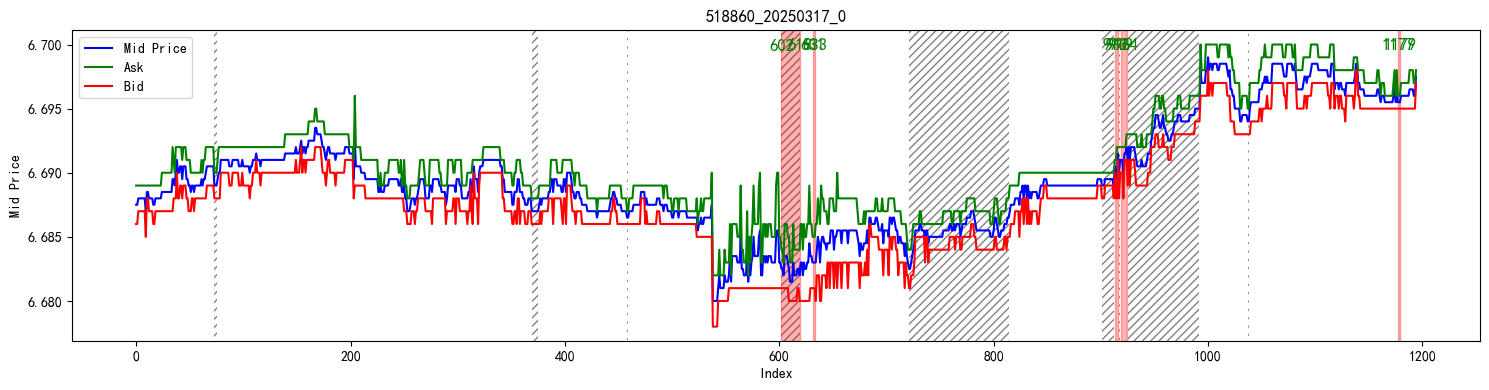

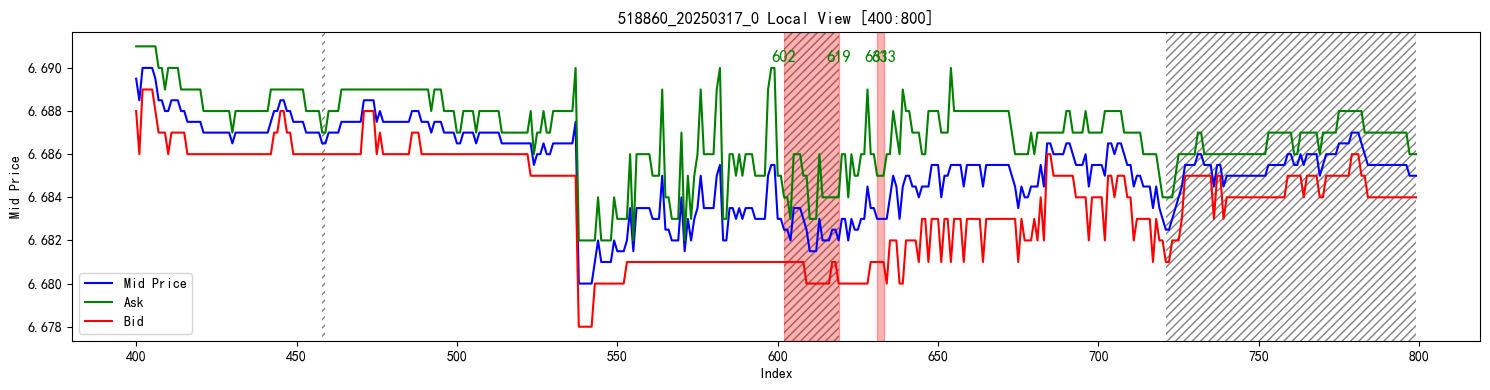

In [48]:
print_diff_row(check_act, acts, obs)
plot_diff_row(_sample_id, check_act, acts, obs, lob_data, 400, 800)
# plot_diff_row(check_act, acts, obs, 4100, 4300)